In [ ]:
import os
import json 
import random
import numpy as np 
import pandas as pd
from tqdm import tqdm 
from PIL import Image
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics import BLEUScore
from torchvision import transforms 
from transformers import ViTFeatureExtractor
from torch.utils.data import Dataset, DataLoader, random_split 
from torch.nn.functional import cross_entropy
from transformers import BertTokenizer, BertModel, ViTModel, BertConfig, AdamW, ViTConfig
from transformers import BertLMHeadModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


C:\Users\omrav\AppData\Roaming\Python\Python311\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\omrav\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any 

In [2]:
class VQA_RAD_Dataset(Dataset):
    def __init__(self, json_dir, img_dir, transform=None):

        with open(json_dir, 'r') as file:
            self.data = json.load(file)

        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_dir , self.data[index]['image_name'])
        question = self.data[index]['question']
        answer = str(self.data[index]['answer'])

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, question, answer

In [3]:
image_dir = r"Dataset\VQA_RAD\VQA_RAD Image Folder"
json_dir = r"Dataset\VQA_RAD\VQA_RAD Dataset Public.json"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = VQA_RAD_Dataset(json_dir=json_dir, img_dir=image_dir, transform=transform)

In [4]:
def custom_collate_fn(batch):
    images, questions, answers = zip(*batch)
    images = torch.stack(images)  
    questions = list(questions)  
    answers = list(answers)      
    return images, questions, answers


train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

print(f"Number of samples in train set: {len(train_dataset)}")
print(f"Number of samples in test set: {len(test_dataset)}")

Number of samples in train set: 1798
Number of samples in test set: 450


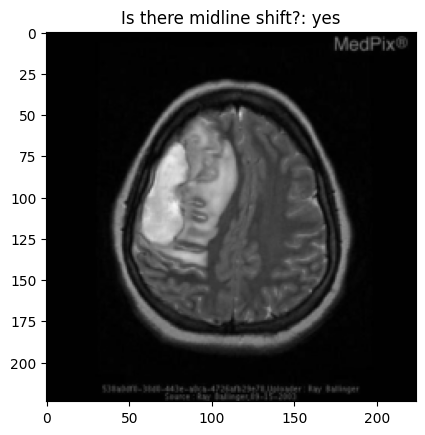

In [5]:
image, question, answer = train_dataset.__getitem__(-1)

image = image.permute(1, 2, 0).numpy()
plt.imshow(image)
plt.title(f"{question}: {answer}")
plt.show()

In [ ]:
class VQAModel(nn.Module):
    def __init__(self, bert, vit, answer_decoder_config):
        super(VQAModel, self).__init__()

        # Store preloaded BERT and ViT models
        self.bert = bert
        self.text_encoder = nn.ModuleList(self.bert.encoder.layer[:6])  # First 6 layers of BERT
        self.multimodal_encoder = nn.ModuleList(self.bert.encoder.layer[6:])  # Last 6 layers of BERT
        self.image_encoder = vit  # Preloaded Vision Transformer

        # Answer Decoder with cross-attention enabled, initialized from the config
        self.answer_decoder = BertLMHeadModel(answer_decoder_config)

    def forward(self, input_ids, attention_mask, images, decoder_input_ids):
        # Step 1: Process Text Encoder (First 6 layers of BERT)
        text_embeddings = self._encode_text(input_ids, attention_mask)

        # Step 2: Process Image Encoder (ViT)
        image_embeddings = self.image_encoder(images).last_hidden_state

        # Step 3: Concatenate Text and Image Embeddings
        combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)

        # Step 4: Create Combined Attention Mask
        combined_attention_mask = torch.cat(
            [attention_mask, torch.ones((attention_mask.size(0), image_embeddings.size(1)), device=attention_mask.device)],
            dim=1
        )

        # Step 5: Process Multimodal Encoder (Last 6 layers of BERT)
        multimodal_embeddings = self._encode_multimodal(combined_embeddings, combined_attention_mask)

        # Output the multimodal embeddings to be used with the answer decoder for token-by-token generation
        return multimodal_embeddings

    def _encode_text(self, input_ids, attention_mask):
        # Initial text embeddings from input IDs using self.bert's embedding layer
        text_embeddings = self.bert.embeddings(input_ids=input_ids)
        
        # Expand attention mask to required shape for BERT encoder layers
        attention_mask_expanded = attention_mask.unsqueeze(1).unsqueeze(2).float()
        attention_mask_expanded = (1.0 - attention_mask_expanded) * -10000.0

        # Process through the first 6 layers of BERT for text encoding
        for layer in self.text_encoder:
            text_embeddings = layer(text_embeddings, attention_mask=attention_mask_expanded)[0]
        
        return text_embeddings

    def _encode_multimodal(self, combined_embeddings, combined_attention_mask):
        # Expand combined attention mask
        combined_attention_mask_expanded = combined_attention_mask.unsqueeze(1).unsqueeze(2).float()
        combined_attention_mask_expanded = (1.0 - combined_attention_mask_expanded) * -10000.0

        # Process through the last 6 layers of BERT for multimodal encoding
        for layer in self.multimodal_encoder:
            combined_embeddings = layer(combined_embeddings, attention_mask=combined_attention_mask_expanded)[0]

        return combined_embeddings


In [7]:
def train_vqa_model(model, dataloader, tokenizer, device='cuda', num_epochs=3, learning_rate=1e-5, model_checkpoint_path="vqa_model_checkpoint.pth"):
    """
    Train the VQA model with checkpointing and metric tracking.

    Parameters:
    - model: VQAModel instance
    - dataloader: DataLoader instance with training data
    - tokenizer: BertTokenizer instance
    - device: torch.device, either 'cuda' or 'cpu'
    - num_epochs: int, number of training epochs
    - learning_rate: float, learning rate for optimizer
    - model_checkpoint_path: str, path to save/load model checkpoint
    - encoder_checkpoint_path: str, path to save/load shared encoders checkpoint
    """
    
    # Define optimizer, loss function, and BLEU metric
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    bleu_metric = BLEUScore()

    # Initialize metric tracking
    metrics_history = {'loss': [], 'bleu_score': []}

    # Load model and optimizer state from checkpoint if available
    start_epoch = 0
    if os.path.exists(model_checkpoint_path):
        checkpoint = torch.load(model_checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch + 1}")

    # Training loop
    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss = 0
        batch_count = len(dataloader)
        bleu_scores = []

        for i, (images, questions, answers) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
            images = images.to(device)
            optimizer.zero_grad()

            # Tokenize questions and answers
            encoding = tokenizer(questions, padding='max_length', truncation=True, max_length=12, return_tensors='pt')
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            decoder_input_ids = torch.tensor([[tokenizer.cls_token_id]] * input_ids.size(0), device=device)

            # Forward pass to get multimodal embeddings
            with torch.no_grad():
                multimodal_embeddings = model(input_ids, attention_mask, images, decoder_input_ids)

            # Generate answers using the answer decoder and calculate loss for each token
            batch_loss = 0
            generated_answers = []  # To store generated answers for BLEU

            for batch_idx in range(multimodal_embeddings.size(0)):
                decoder_input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
                target_ids = tokenizer.encode(answers[batch_idx], add_special_tokens=True)
                target_ids = torch.tensor(target_ids, device=device)
                answer_tokens = []

                for i in range(len(target_ids) - 1):  # Iterate through each token in target
                    outputs = model.answer_decoder(
                        input_ids=decoder_input_ids,
                        encoder_hidden_states=multimodal_embeddings[batch_idx].unsqueeze(0)
                    )
                    logits = outputs.logits[:, -1, :]  # Get logits for last token
                    next_token_id = target_ids[i + 1]  # Next token in the target sequence

                    # Calculate loss for the current token
                    loss = criterion(logits, next_token_id.unsqueeze(0))
                    batch_loss += loss

                    # Update the decoder input with next token
                    decoder_input_ids = torch.cat([decoder_input_ids, next_token_id.unsqueeze(0).unsqueeze(0)], dim=1)
                    answer_tokens.append(next_token_id.item())
                    if next_token_id.item() == tokenizer.sep_token_id:
                        break

                # Decode generated answer tokens and calculate BLEU score
                generated_answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
                generated_answers.append(generated_answer)
                bleu_scores.append(bleu_metric(generated_answer, [answers[batch_idx]]).item())

            # Average loss for the batch
            batch_loss /= len(target_ids) - 1
            total_loss += batch_loss.item()

            # Backpropagation
            batch_loss.backward()
            optimizer.step()

        # Calculate metrics for the epoch
        avg_loss = total_loss / len(dataloader)
        avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
        metrics_history['loss'].append(avg_loss)
        metrics_history['bleu_score'].append(avg_bleu_score)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, Avg BLEU: {avg_bleu_score:.4f}")

        # Save model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'bleu_score': avg_bleu_score
        }, model_checkpoint_path)
        print(f"Model checkpoint saved at epoch {epoch + 1}")

    print("Training complete.")
    return metrics_history


In [8]:
def load_pretrained_models(bert_checkpoint_path, vit_checkpoint_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Load pre-trained BERT and Vision Transformer models from state_dict checkpoints.
    
    Parameters:
    - bert_checkpoint_path (str): Path to the BERT model checkpoint (.pth file).
    - vit_checkpoint_path (str): Path to the Vision Transformer model checkpoint (.pth file).
    - device (str): Device to load models onto, 'cuda' or 'cpu'.
    
    Returns:
    - bert_model: Loaded BERT model with pre-trained weights.
    - vit_model: Loaded Vision Transformer model with pre-trained weights.
    """
    
    # Load BERT configuration and model
    bert_config = BertConfig.from_pretrained('bert-base-uncased')
    bert_model = BertModel(bert_config)
    bert_checkpoint = torch.load(bert_checkpoint_path, map_location=device)
    bert_model.load_state_dict(bert_checkpoint)
    bert_model.to(device)
    bert_model.eval()  # Set to evaluation mode if not training

    # Load Vision Transformer configuration and model
    vit_config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
    vit_model = ViTModel(vit_config)
    vit_checkpoint = torch.load(vit_checkpoint_path, map_location=device)
    vit_model.load_state_dict(vit_checkpoint)
    vit_model.to(device)
    vit_model.eval()  # Set to evaluation mode if not training

    return bert_model, vit_model

In [9]:
bert_checkpoint_path = "bert_model_checkpoint.pth"
vit_checkpoint_path = "image_encoder_checkpoint.pth"

bert, vit = load_pretrained_models(bert_checkpoint_path, vit_checkpoint_path, device=device)

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# bert = BertModel.from_pretrained('bert-base-uncased')
# vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# Configure the answer decoder with cross-attention enabled
answer_decoder_config = BertConfig.from_pretrained('bert-base-uncased')
answer_decoder_config.is_decoder = True
answer_decoder_config.add_cross_attention = True

# Initialize the VQA model with preloaded models
model = VQAModel(bert, vit, answer_decoder_config).to(device)

In [11]:
epochs = 8
metric_history = train_vqa_model(model, train_dataloader, tokenizer, num_epochs=epochs)

d:\Anaconda\envs\CUDA1\Lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `BLEUScore` from `torchmetrics` was deprecated and will be removed in 2.0. Import `BLEUScore` from `torchmetrics.text` instead.
  _future_warning(


Resuming training from epoch 9
Training complete.


In [12]:
def evaluate_vqa_model(model, dataloader, tokenizer):
    device = next(model.parameters()).device
    model.to(device)
    model.eval() 

    bleu = BLEUScore()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    total_bleu = 0
    num_batches = 0

    # Iterate over the test set
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            images, questions, answers = batch
            images = images.to(device)
            
            # Tokenize the questions and answers
            encoding = tokenizer(questions, padding='max_length', truncation=True, max_length=12, return_tensors='pt')
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            # Prepare the decoder input by starting with the [CLS] token
            decoder_input_ids = torch.tensor([[tokenizer.cls_token_id]] * input_ids.size(0), device=device)

            # Forward pass to get multimodal embeddings
            multimodal_embeddings = model(input_ids, attention_mask, images, decoder_input_ids)
            batch_loss = 0
            generated_answers = []

            # Generate answers and calculate loss for each token
            for batch_idx in range(multimodal_embeddings.size(0)):
                decoder_input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
                target_ids = tokenizer.encode(answers[batch_idx], add_special_tokens=True)
                target_ids = torch.tensor(target_ids, device=device)
                answer_tokens = []

                for i in range(len(target_ids) - 1):  # Iterate through each token in target
                    outputs = model.answer_decoder(
                        input_ids=decoder_input_ids,
                        encoder_hidden_states=multimodal_embeddings[batch_idx].unsqueeze(0)
                    )
                    logits = outputs.logits[:, -1, :]  # Get the logits for the last generated token
                    next_token_id = target_ids[i + 1]  # Next token in the target sequence

                    # Calculate loss for the current token
                    loss = criterion(logits, next_token_id.unsqueeze(0))
                    batch_loss += loss

                    # Update the decoder input with the next token
                    decoder_input_ids = torch.cat([decoder_input_ids, next_token_id.unsqueeze(0).unsqueeze(0)], dim=1)
                    answer_tokens.append(next_token_id.item())

                    if next_token_id.item() == tokenizer.sep_token_id:
                        break

                # Decode tokens to text and add to generated answers
                answer_text = tokenizer.decode(answer_tokens, skip_special_tokens=True)
                generated_answers.append(answer_text)

            # Average loss for the batch
            batch_loss /= len(target_ids) - 1
            total_loss += batch_loss.item()
            
            # Calculate BLEU score for each answer pair in the batch
            for gen_answer, gt_answer in zip(generated_answers, answers):
                total_bleu += bleu(gen_answer.split(), gt_answer.split())

            num_batches += 1

    # Calculate the average BLEU score and loss over all batches
    avg_loss = total_loss / num_batches
    avg_bleu = total_bleu / num_batches

    print(f"Test Loss: {avg_loss:.4f}, BLEU Score: {avg_bleu:.4f}")
    return avg_loss, avg_bleu

In [13]:
test_loss, test_bleu = evaluate_vqa_model(model, test_dataloader, tokenizer)

Evaluating:   2%|▏         | 1/57 [00:02<02:23,  2.57s/it]


KeyboardInterrupt: 

In [14]:
def process_batch(batch, tokenizer):
    images, questions, answers = batch  # Extract images, questions, and answers
    encoding = tokenizer(
        questions,
        padding='max_length',
        truncation=True,
        max_length=12,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    images = images.to(torch.float32)  # Ensure images are float32
    return images, questions, answers, input_ids, attention_mask    

In [15]:
def test_vqa_model_on_batch(model, dataloader, tokenizer, max_answer_length=20):
    """
    Tests the VQAModel on a single batch from the dataloader.
    
    Parameters:
        model (VQAModel): The VQA model to test.
        dataloader (DataLoader): DataLoader containing the test data.
        tokenizer (BertTokenizer): Tokenizer for encoding and decoding.
        max_answer_length (int): Maximum length for generated answers.
    """
    # Ensure model is on the correct device
    device = next(model.parameters()).device

    # Iterate over one batch
    for batch in dataloader:
        # Process batch and move inputs to model's device
        images, questions, ground_truth_answers, input_ids, attention_mask = process_batch(batch, tokenizer)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        images = images.to(device)
        decoder_input_ids = torch.tensor([[tokenizer.cls_token_id]] * input_ids.size(0), device=device)

        # Forward pass through the model
        with torch.no_grad():
            answer_logits = model(input_ids, attention_mask, images, decoder_input_ids)

        # Greedy decoding to generate answers
        generated_answers = []
        for batch_idx in range(answer_logits.size(0)):
            decoder_input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
            answer_tokens = []

            for _ in range(max_answer_length):
                outputs = model.answer_decoder(
                    input_ids=decoder_input_ids,
                    encoder_hidden_states=answer_logits[batch_idx].unsqueeze(0)
                )
                
                logits = outputs.logits[:, -1, :]  # Get logits for the last generated token
                next_token_id = logits.argmax(dim=-1)

                answer_tokens.append(next_token_id.item())
                decoder_input_ids = torch.cat([decoder_input_ids, next_token_id.unsqueeze(0)], dim=1)

                if next_token_id.item() == tokenizer.sep_token_id:
                    break

            # Decode tokens to text and add to answers
            answer_text = tokenizer.decode(answer_tokens, skip_special_tokens=True)
            generated_answers.append(answer_text)

        # Display the question, generated answer, and ground truth answer
        for i in range(len(questions)):
            print(f"Question: {questions[i]}")
            print(f"Generated Answer: {generated_answers[i]}")
            print(f"Ground Truth Answer: {ground_truth_answers[i]}")
            print("-" * 50)  # Separator for readability

        # Only process one batch
        break

In [16]:
test_vqa_model_on_batch(model, test_dataloader, tokenizer)

Question: Is there fat stranding?
Generated Answer: no
Ground Truth Answer: No
--------------------------------------------------
Question: What are seen as hyperdense in the mediastinum of this image?
Generated Answer: right
Ground Truth Answer: Sternal wires
--------------------------------------------------
Question: Is there free air under the diaphragm?
Generated Answer: yes
Ground Truth Answer: No
--------------------------------------------------
Question: Did the patient have a cholecystectomy?
Generated Answer: yes
Ground Truth Answer: Yes
--------------------------------------------------
Question: Is there a vertebral fracture?
Generated Answer: no
Ground Truth Answer: No
--------------------------------------------------
Question: What is the term for the sign in this image?
Generated Answer: right
Ground Truth Answer: right vertebral artery sign
--------------------------------------------------
Question: was the arterial contrast phase selected?
Generated Answer: yes
Grou

In [17]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

In [19]:
cam_extractor = GradCAM(model, target_layer=model.multimodal_encoder[-1])

# Prepare the sample data
single_image, question, answer = dataset[0]  # Load a sample from the dataset

# Ensure the image is a tensor and on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
if not isinstance(single_image, torch.Tensor):
    single_image = transforms.ToTensor()(single_image)
single_image = single_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Tokenize the question for model input
encoding = tokenizer(
    question, 
    return_tensors='pt', 
    padding='max_length', 
    truncation=True, 
    max_length=13
).to(device)

input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

# Initialize decoder_input_ids with the start token (e.g., [CLS] token for BERT-based models)
decoder_input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)

# Forward pass to get logits and register hooks for Grad-CAM
output = model(input_ids=input_ids, attention_mask=attention_mask, images=single_image, decoder_input_ids=decoder_input_ids)

# Choose an index for the answer (e.g., maximum logit value for prediction)
predicted_answer_idx = output.argmax().item()

# Generate the CAM for the selected class
activation_map = cam_extractor(predicted_answer_idx, output)

# Post-process and overlay CAM on the original image
# Convert single_image back to CPU and remove batch dimension for visualization
input_image_np = single_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Resize activation map to match the image size
activation_map = activation_map[0].cpu().numpy()  # Get the activation map as a numpy array
activation_map_resized = np.array(Image.fromarray(activation_map).resize(input_image_np.shape[:2][::-1], Image.BILINEAR))

# Overlay the activation map on the image
result = overlay_mask(Image.fromarray((input_image_np * 255).astype(np.uint8)), Image.fromarray((activation_map_resized * 255).astype(np.uint8), mode='L'), alpha=0.5)

# Display the result
plt.imshow(result)
plt.axis('off')
plt.show()

AttributeError: 'tuple' object has no attribute 'data'

In [20]:
output 

NameError: name 'output' is not defined